# Data Dimensionality
As for tabular data, the first thing to understand is the data dimensionality. In the case of a single time series, it's simple - we are in the presence of one single dimension. But usually, in this context, dimensionality corresponds to the number of observations taken, which corresponds to the length of the series.
So after loading the data, the usual procedure is to plot the data at the most atomic granularity to look for regularities (repetitions) in the data.

In [11]:
from pandas import read_csv
import matplotlib.pyplot as plt
from ts_functions import plot_series, HEIGHT
import ds_charts as ds
from numpy import ones
from pandas import Series

%run p00_settings.ipynb

data = read_csv(project_path + data_file, index_col=time_var, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
data = data[[target, "stock"]]

print("Nr. Records =", data.shape[0])
print("First date:", data.index[0])
print("Last date:", data.index[-1])
print("Number of Temporal Points (weeks) =", len(data.index.unique()))

Nr. Records = 750
First date: 2011-01-07 00:00:00
Last date: 2011-06-24 00:00:00
Number of Temporal Points (weeks) = 25


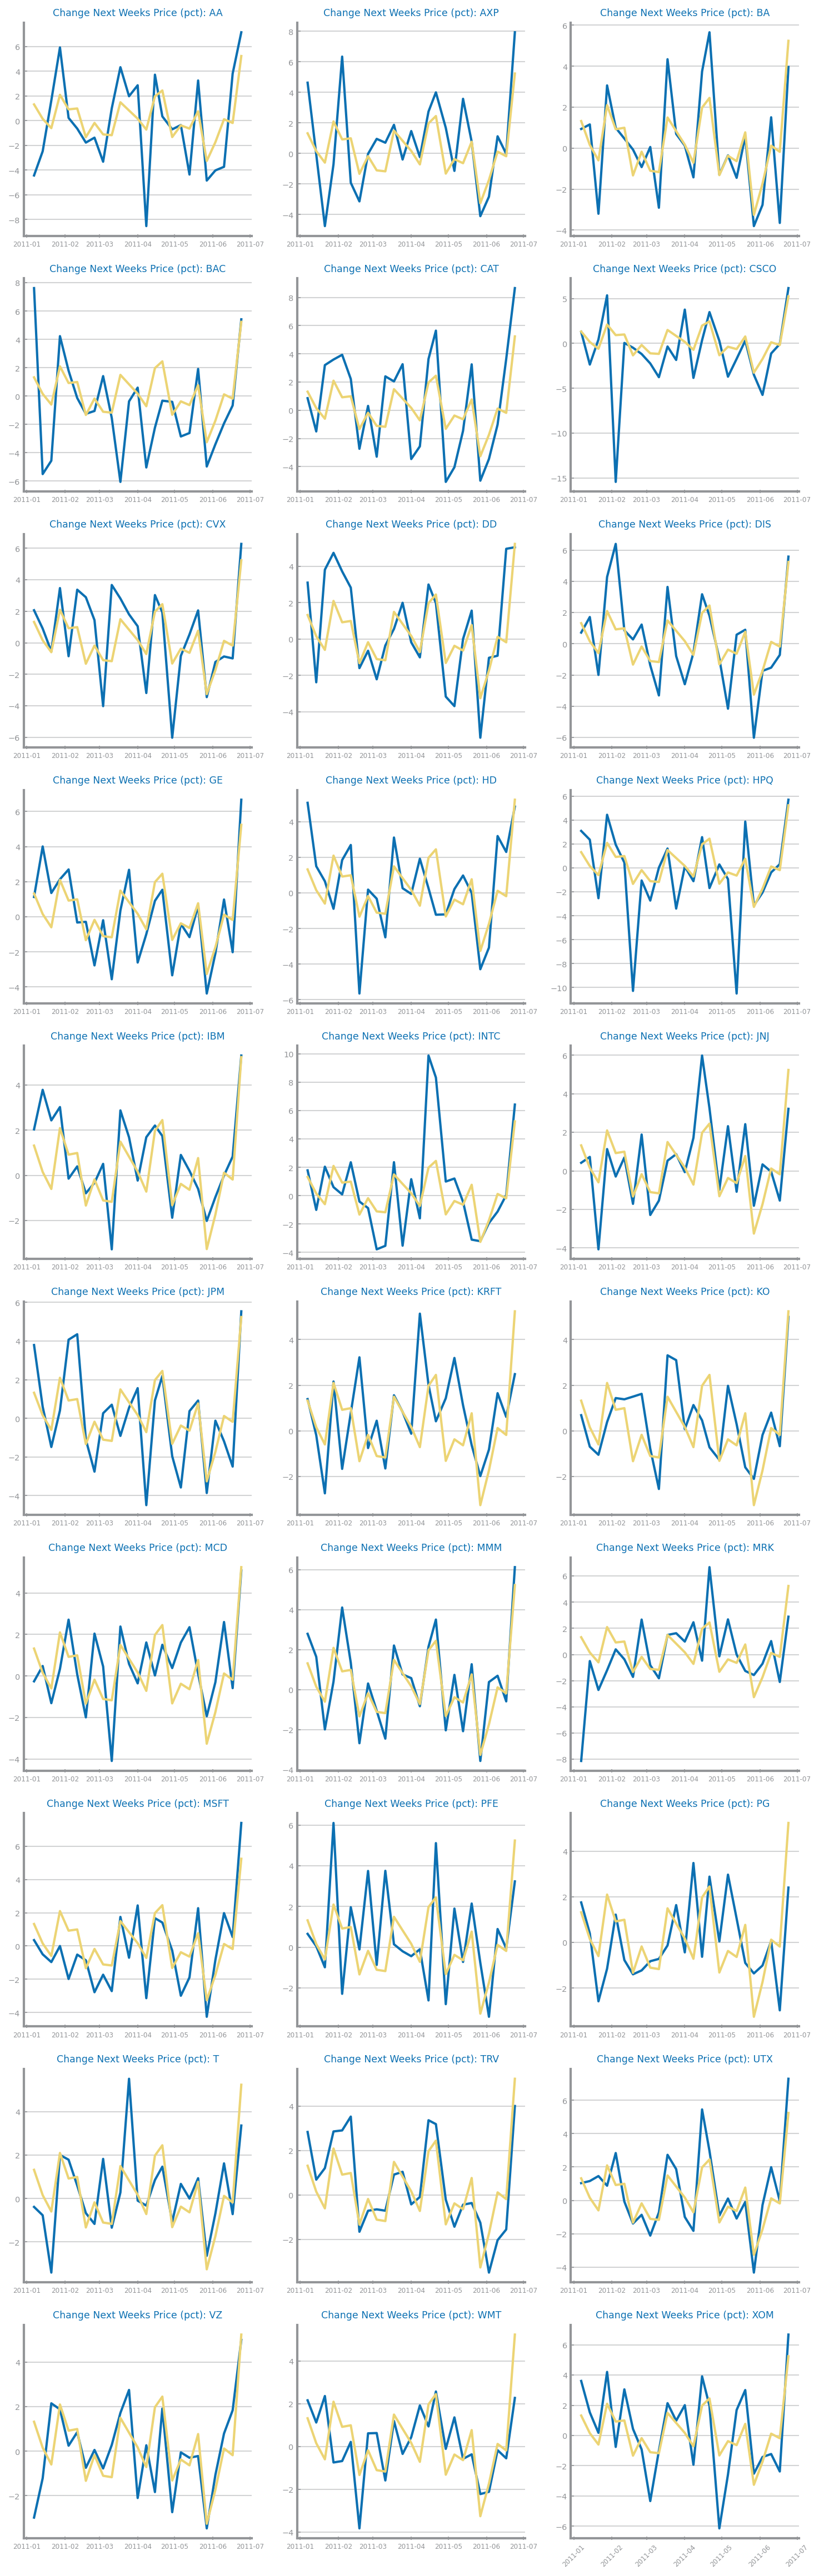

In [12]:
stock_tickers = data["stock"].unique()
rows, cols = ds.choose_grid(len(stock_tickers))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(stock_tickers)):
    stock_data = data.loc[data['stock'] == stock_tickers[n]]
    axs[i, j].set_title('Change Next Weeks Price (pct): %s'%stock_tickers[n])
    axs[i, j].plot(stock_data[target])
    axs[i, j].plot(data[target].groupby(time_var).mean())
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.savefig(project_path + '03_images/target_timeseries_by_stock.png')
plt.xticks(rotation = 45)
plt.show()

The plot shows the % change in next weeks price for each stock composing the Dow Jones index during the year of 2011, weekly measured, totalizing 750 observations.

There some interesting things we can see from looking at the chart:

- first, there are some stocks that seem to have a higher correlation to the average dow jones % price change;
- second, the series seems stationary, maybe due to the information being variation wise, which decresases non stationary behaviour;
- third, the series seems to present a spike for every stock in the last weeks.
- and forth, in the 27th May week, every single stock had a negative % price change.

# Data Granularity
The data is already in a weekly basis and has only 750 observations, thus we will not proceed with data granularization.

# Data Distribution
Like for tabular data, one of the perspectives of analysis to consider is the distribution of data, in particular the centrality, trends and distribution of the variable. But be aware that the different aggregations may show different distributions.

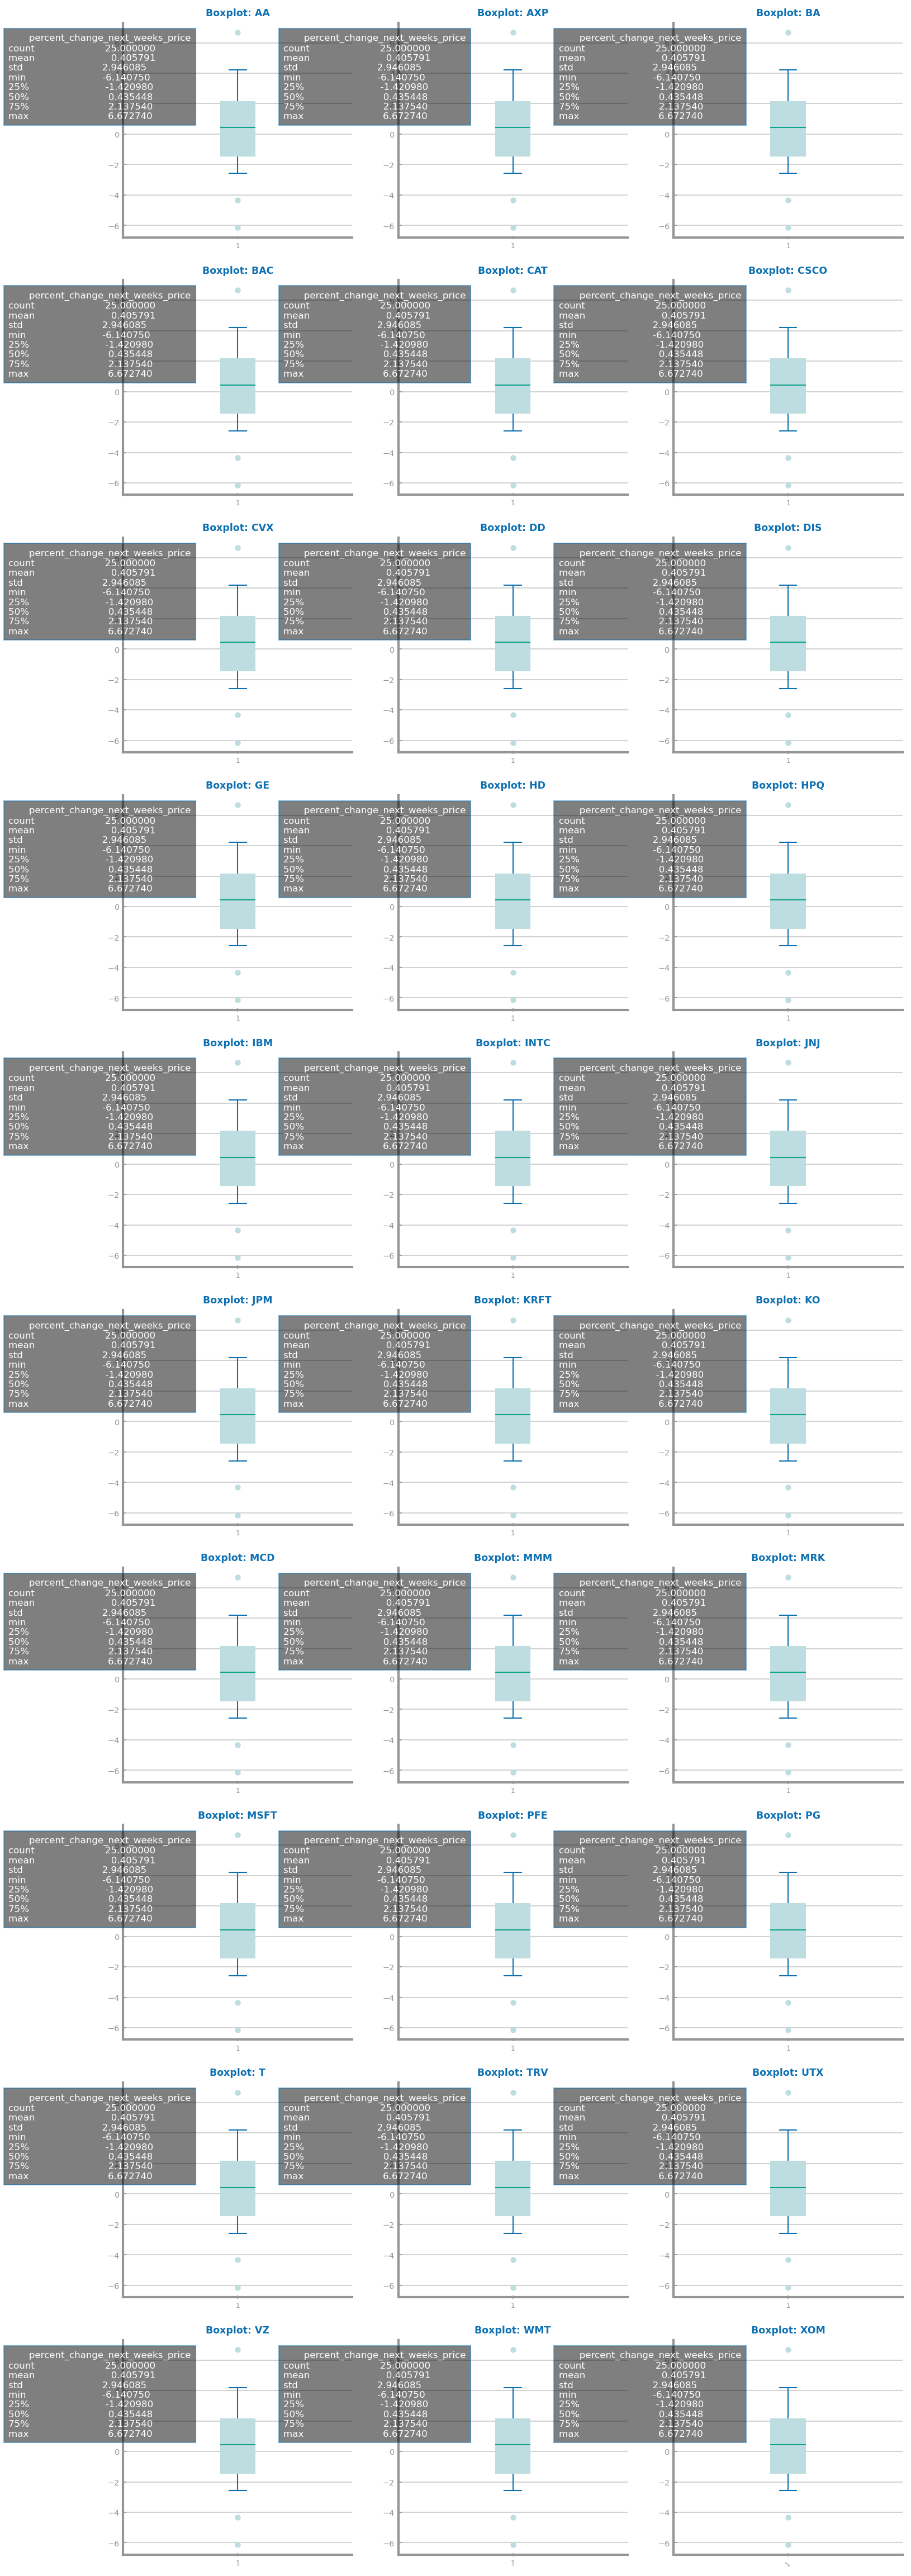

In [15]:
i, j = 0, 0
rows, cols = ds.choose_grid(len(stock_tickers))
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
for n in range(len(stock_tickers)):
    axs[i, j].set_title('Boxplot: %s'%stock_tickers[n] ,fontweight="bold")
    axs[i, j].boxplot(stock_data[target])
    axs[i, j].text( 0, 
                    1, 
                    str(stock_data.describe()), 
                    bbox = dict(facecolor='black', 
                                alpha=0.5), 
                                fontsize=8, 
                                color="white")
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.savefig(project_path + '03_images/target_boxplot_by_stock.png')
plt.xticks(rotation = 45)
plt.show()

# Variables Distribution
But from this chart is not possible to completely understand the variable distribution. In order to do so, we use histograms:
1. Total stocks histogram (average return per week);
2. Histogram per stock.

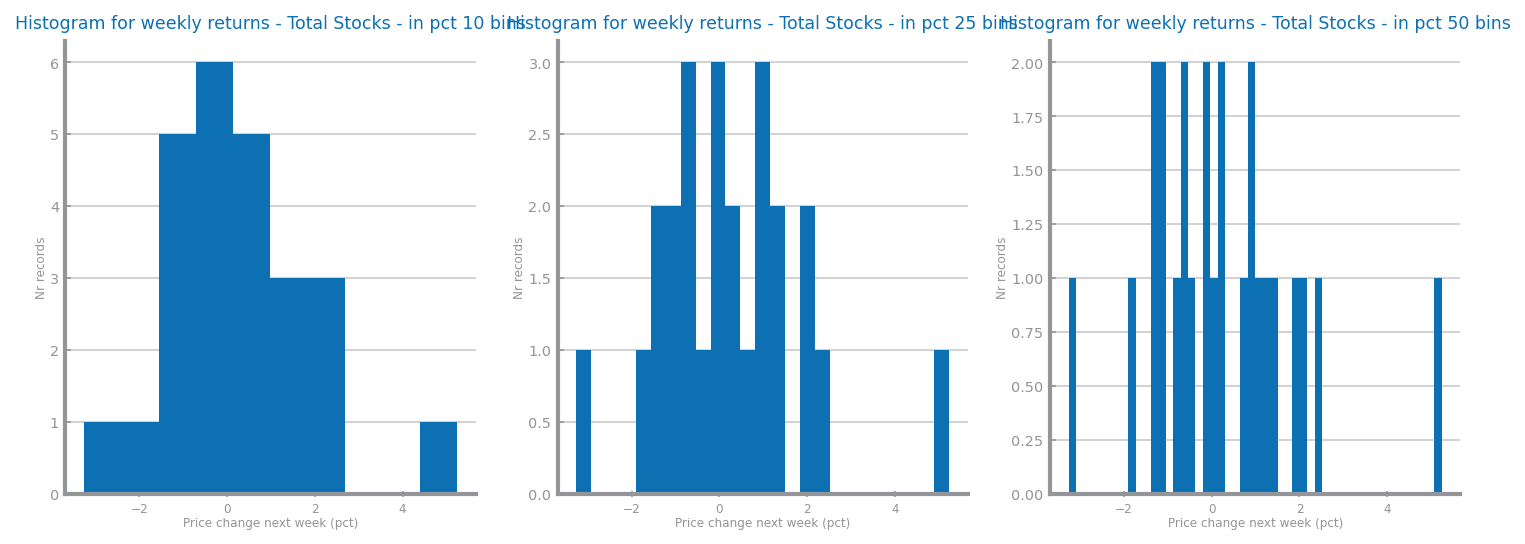

In [17]:
bins = (10, 25, 50)
fig, axs = plt.subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
j = 0
for j in range(len(bins)):
  axs[j].set_title(f'Histogram for weekly returns - Total Stocks - in pct {bins[j]} bins')
  axs[j].set_xlabel('Price change next week (pct)')
  axs[j].set_ylabel('Nr records')
  axs[j].hist(data[target].groupby(time_var).mean(), bins=bins[j])
plt.savefig(project_path + '03_images/weekly_total_returns_hist.png')
plt.show()

Looking at the histogram, it seems that the returns might follow a normal distribution. however, there are few data points (25 weeks only) to confirm this. Let us take a closer look at the histograms for each stock:

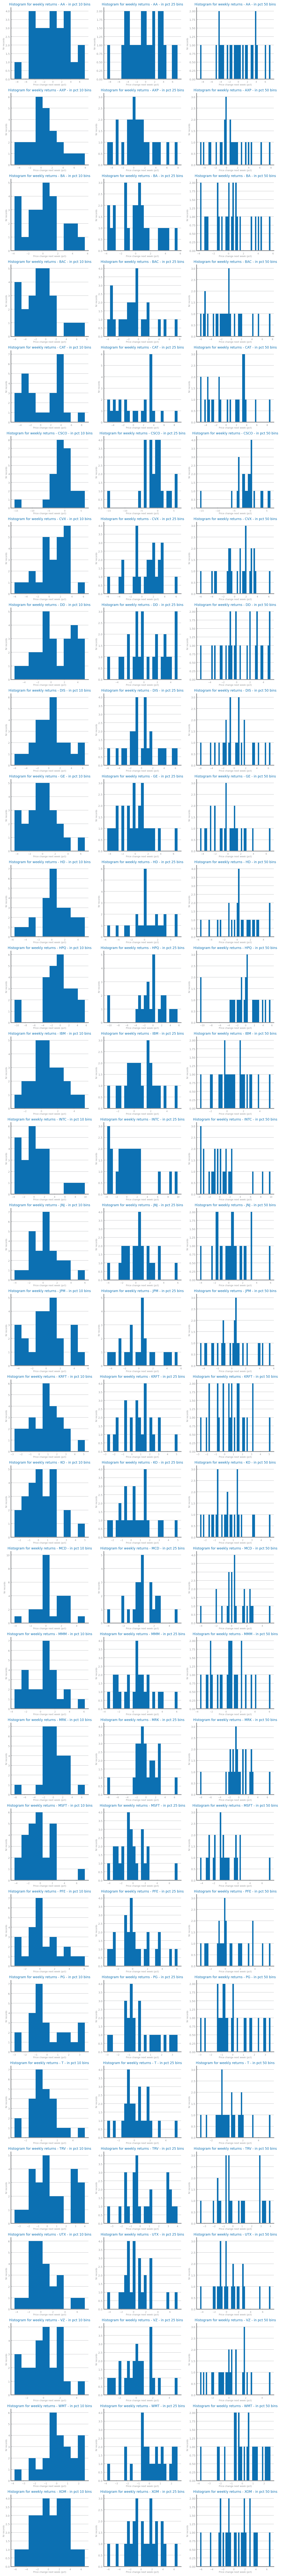

In [18]:
rows, cols = ds.choose_grid(len(stock_tickers))
fig, axs = plt.subplots(len(stock_tickers), len(bins), figsize=(len(bins)*HEIGHT, len(stock_tickers)*HEIGHT))
i, j = 0, 0
for i in range(len(stock_tickers)):
    stock_data = data.loc[data['stock'] == stock_tickers[i]]
    for j in range(len(bins)):
        axs[i, j].set_title(f'Histogram for weekly returns - {stock_tickers[i]} - in pct {bins[j]} bins')
        axs[i, j].set_xlabel('Price change next week (pct)')
        axs[i, j].set_ylabel('Nr records')
        axs[i, j].hist(stock_data[target], bins=bins[j])
plt.savefig(project_path + '03_images/weekly_stock_returns_hist.png')
plt.show()

In the histograms above we can recognize that not all stocks data follow a normal distribution, despite the first histogram of the total average returns induce it.

Note the importance of creating the histogram for the most adequate data granularity, for the task at hands.

### Data Stationarity

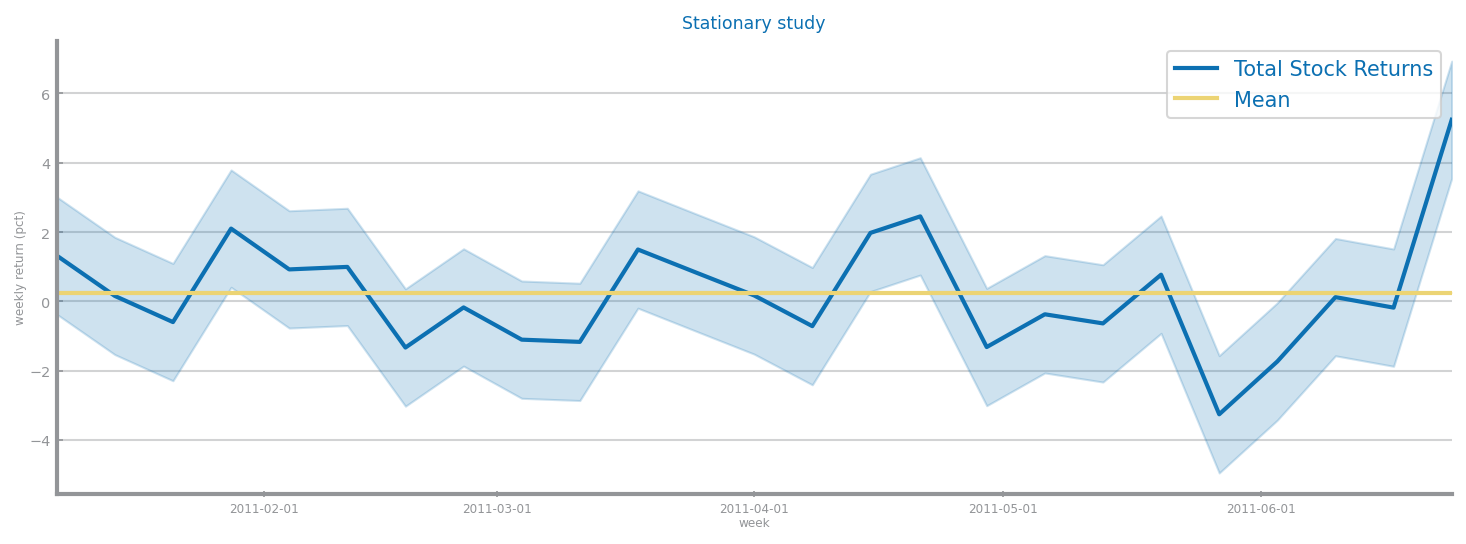

In [19]:
dt_series = Series(data[target].groupby(time_var).mean())

mean_line = Series(ones(len(dt_series.values)) * dt_series.mean(), index=dt_series.index)
series = {'Total Stock Returns': dt_series, 'Mean': mean_line}
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(series, x_label='week', y_label='weekly return (pct)', title='Stationary study', show_std=True)
plt.savefig(project_path + '03_images/total_stock_stationarity_study.png')
plt.show()

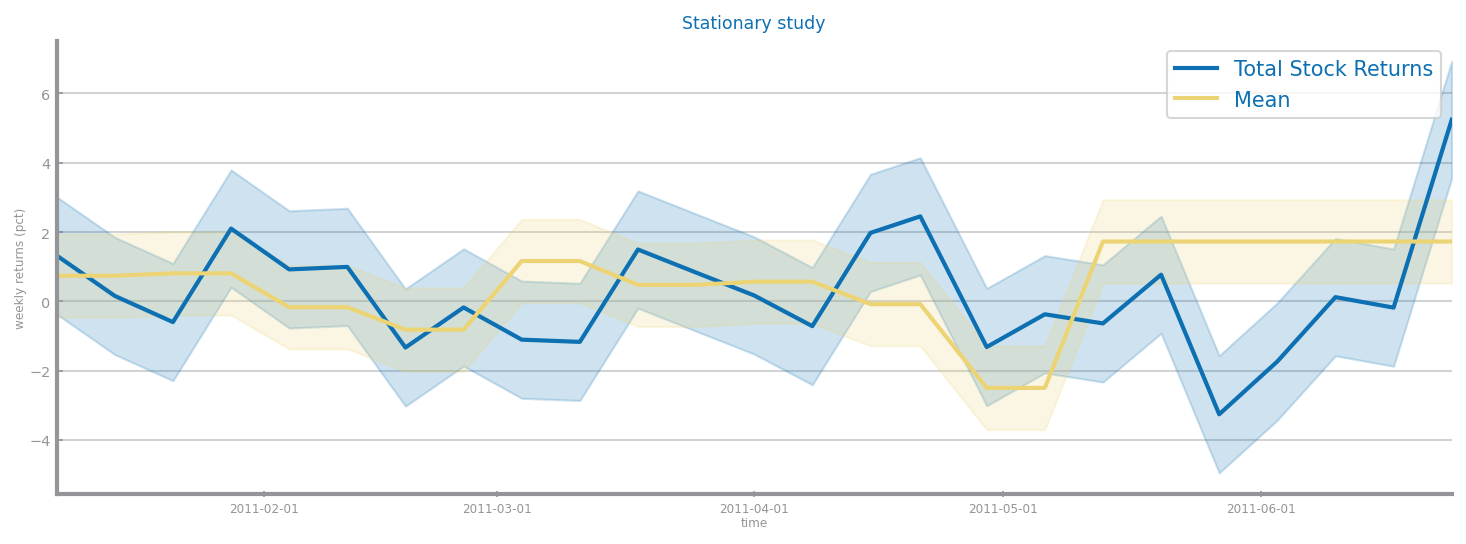

In [20]:
BINS = 10
line = []
n = len(dt_series)
for i in range(BINS):
    b = dt_series[i*n//BINS:(i+1)*n//BINS]
    mean = [b.mean()] * (n//BINS)
    line += mean
line += [line[-1]] * (n - len(line))
mean_line = Series(line, index=dt_series.index)
series = {'Total Stock Returns': dt_series, 'Mean': mean_line}
plt.figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(series, x_label='time', y_label='weekly returns (pct)', title='Stationary study', show_std=True)
plt.savefig(project_path + '03_images/total_stock_stationarity_study_bins.png')

plt.show()